In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.__version__)

1.15.0


## 1. Load the MNIST dataset

  * Divide the dataset into 3 splits with the ratios of train : val : test = 5 : 1 : 1 (10 pt)

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28*28)
test_images = test_images.reshape(test_images.shape[0], 28*28)

# print('Train data shape: {}, {}'.format(train_images.shape, train_labels.shape))
# print('Test data shape: {}, {}'.format(test_images.shape, test_labels.shape))

X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels,
                                                      test_size=1/6, random_state=1207)

y_train = to_categorical(y_train, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)
X_test, y_test = test_images, to_categorical(test_labels, num_classes=10)

print('Train data shape: {}, {}'.format(X_train.shape, y_train.shape))
print('Valid data shape: {}, {}'.format(X_valid.shape, y_valid.shape))
print('Test data shape: {}, {}'.format(X_test.shape, y_test.shape))

Train data shape: (50000, 784), (50000, 10)
Valid data shape: (10000, 784), (10000, 10)
Test data shape: (10000, 784), (10000, 10)


## 2. Train a model on the MNIST dataset

   * For all your training results, plot the training and validation curve and report the test accuracy

#### 2.1 Create the base model with 2-layer MLP (10 pt)

In [5]:
def next_batch(n_batch, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:n_batch]
    
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]

    return data_shuffle, labels_shuffle

In [24]:
def run_session(params):
    def build_model(x, weights, biases):
        nonlocal layer_num

        hidden = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
        hidden_final = tf.nn.relu(hidden)

        if layer_num == 3:
            hidden_middle = tf.add(tf.matmul(hidden_final, 
                                             weights['hidden_middle']), 
                                             biases['hidden_middle'])
            hidden_final = tf.nn.relu(hidden_middle)

        output = tf.add(tf.matmul(hidden_final, weights['output']), biases['output'])

        return output

    layer_num = len(params['n_hiddens']) + 1
    
    n_input, n_output = params['n_input'], params['n_output']
    LR, n_batch = params['LR'], params['n_batch']
    n_iter, n_prt = params['n_iter'], params['n_prt']
    
    n_hidden = params['n_hiddens']['n_hidden']
    
    weights = {'hidden': tf.Variable(tf.random.normal([n_input, n_hidden], stddev=0.05))}
    biases = {'hidden': tf.Variable(tf.random.normal([n_hidden], stddev=0.05)),
              'output': tf.Variable(tf.random.normal([n_output], stddev=0.05))}
    if layer_num == 2:
        weights['output'] = tf.Variable(tf.random.normal([n_hidden, n_output], stddev=0.05))
        
    if layer_num == 3:
        n_hidden_middle = params['n_hiddens']['n_hidden_middle']
        
        weights['hidden_middle'] = tf.Variable(
            tf.random.normal([n_hidden, n_hidden_middle], stddev=0.05))
        weights['output'] = tf.Variable(
            tf.random.normal([n_hidden_middle, n_output], stddev=0.05))
        biases['hidden_middle'] = tf.Variable(
            tf.random.normal([n_hidden_middle], stddev=0.05))
    
    x = tf.compat.v1.placeholder(tf.float32, [None, n_input])
    y = tf.compat.v1.placeholder(tf.float32, [None, n_output])

    pred = build_model(x, weights, biases)
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y)
    loss = tf.reduce_mean(loss)

    optm = tf.compat.v1.train.AdamOptimizer(LR).minimize(loss)
    init = tf.compat.v1.global_variables_initializer()

    loss_record_train = []
    loss_record_valid = []
    with tf.compat.v1.Session() as sess:
        sess.run(init)
        for epoch in range(n_iter):
            train_x, train_y = next_batch(n_batch, X_train, y_train)
            sess.run(optm, feed_dict={x: train_x, y: train_y}) 

            if epoch % n_prt == 0:
                valid_x, valid_y = next_batch(n_batch, X_valid, y_valid)
                c1 = sess.run(loss, feed_dict={x: train_x, y: train_y})
                c2 = sess.run(loss, feed_dict={x: valid_x, y: valid_y})
                loss_record_train.append(c1)
                loss_record_valid.append(c2)
                print ('Iter: {} \tCost: {}'.format(epoch, c1))

        #test accuracy
        test_x, test_y = X_test, y_test
        
        my_pred = sess.run(pred, feed_dict={x: test_x})
        my_pred = np.argmax(my_pred, axis=1)
        labels = np.argmax(test_y, axis=1)

        test_acc = np.mean(np.equal(my_pred, labels))
        if 'base' in params_dict:
            print('\n\n{} Test Accuracy: {}% (base: {}%)'.format(
                params['comment'], round(test_acc*100, 4), round(params['base']*100, 4)))
        else:
            print('\n\n{} Test Accuracy: {}%'.format(
                params['comment'], round(test_acc*100, 4)))
        
    return test_acc, loss_record_train, loss_record_valid

#### 2.2 Train the base model (10 pt)

In [16]:
def plot_loss(loss_record_train, loss_record_test, title):
    n_prt = params_dict['n_prt']
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(loss_record_train))*n_prt,
             loss_record_train, label='Train')
    plt.plot(np.arange(len(loss_record_test))*n_prt, 
             loss_record_test, label='Valid')
    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim([0, np.max(loss_record_train)])
    plt.legend(fontsize=12)
    plt.title('{} Model Loss'.format(title), fontsize=18)
    plt.grid()
    plt.show()

In [25]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 100},
    'n_output': 10, 'LR': 0.0001, 'comment': 'Base',
    'n_batch': 50, 'n_iter': 5000, 'n_prt': 250
}

base_test_acc, base_loss_record_train, base_loss_record_valid = run_session(params_dict)

2021-10-26 10:12:14.159209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:12:14.160123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:12:14.161068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:12:14.161950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:12:14.162012: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 63.36830139160156
Iter: 250 	Cost: 6.07767391204834
Iter: 500 	Cost: 2.6130728721618652
Iter: 750 	Cost: 1.5449105501174927
Iter: 1000 	Cost: 1.8308589458465576
Iter: 1250 	Cost: 0.5474734902381897
Iter: 1500 	Cost: 1.8602664470672607
Iter: 1750 	Cost: 0.16835136711597443
Iter: 2000 	Cost: 0.4368812143802643
Iter: 2250 	Cost: 0.6342354416847229
Iter: 2500 	Cost: 1.0397969484329224
Iter: 2750 	Cost: 0.9325671195983887
Iter: 3000 	Cost: 0.19165006279945374
Iter: 3250 	Cost: 1.0289379358291626
Iter: 3500 	Cost: 0.23266319930553436
Iter: 3750 	Cost: 1.1156151294708252
Iter: 4000 	Cost: 0.49432751536369324
Iter: 4250 	Cost: 0.056169480085372925
Iter: 4500 	Cost: 0.3431268334388733
Iter: 4750 	Cost: 0.14511661231517792


Base Test Accuracy: 92.99%


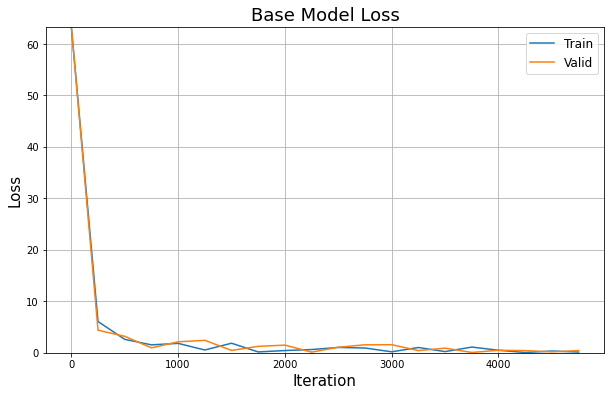

In [26]:
plot_loss(base_loss_record_train, base_loss_record_valid, params_dict['comment'])

#### 2.3 Try to improve your model by tuning the hyperparameters for each case (10 pt)

 * the number of hidden layers
 * the number of hidden nodes
 * the number of epochs
 * learning rate

##### 2.3.1 The Number of Hidden Layers

In [27]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 100, 'n_hidden_middle': 100},
    'n_output': 10, 'LR': 0.0001, 'comment': '2 Hidden Layers',
    'n_batch': 50, 'n_iter': 5000, 'n_prt': 250, 'base': base_test_acc
}

hly_test_acc, hly_loss_record_train, hly_loss_record_valid = run_session(params_dict)

2021-10-26 10:12:34.528223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:12:34.529108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:12:34.529997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:12:34.530873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:12:34.530941: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 21.232471466064453
Iter: 250 	Cost: 1.5176571607589722
Iter: 500 	Cost: 0.3295581340789795
Iter: 750 	Cost: 0.9062109589576721
Iter: 1000 	Cost: 0.052352115511894226
Iter: 1250 	Cost: 0.34715092182159424
Iter: 1500 	Cost: 0.40489909052848816
Iter: 1750 	Cost: 0.26443013548851013
Iter: 2000 	Cost: 0.3303273022174835
Iter: 2250 	Cost: 0.04214254766702652
Iter: 2500 	Cost: 0.29804110527038574
Iter: 2750 	Cost: 0.1299251765012741
Iter: 3000 	Cost: 0.17965461313724518
Iter: 3250 	Cost: 0.2236468493938446
Iter: 3500 	Cost: 0.11681129783391953
Iter: 3750 	Cost: 0.08348716795444489
Iter: 4000 	Cost: 0.028101520612835884
Iter: 4250 	Cost: 0.05754183605313301
Iter: 4500 	Cost: 0.16212411224842072
Iter: 4750 	Cost: 0.013159137219190598


2 Hidden Layers Test Accuracy: 94.27% (base: 92.99%)


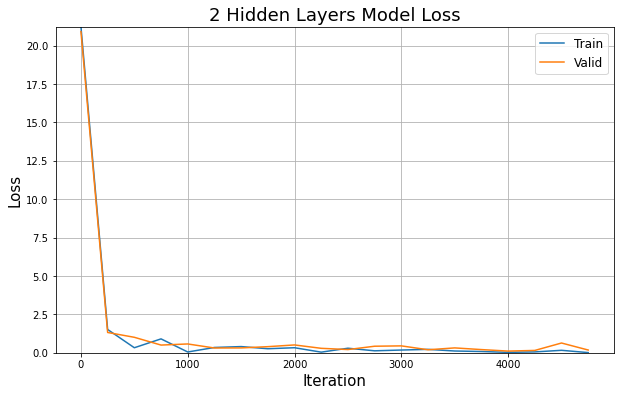

In [28]:
plot_loss(hly_loss_record_train, hly_loss_record_valid, params_dict['comment'])

##### 2.3.2 The Number of Hidden Nodes

In [29]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 1000},
    'n_output': 10, 'LR': 0.0001, 'comment': '1000 Hidden Nodes',
    'n_batch': 50, 'n_iter': 5000, 'n_prt': 250, 'base': base_test_acc
}

hnd_test_acc, hnd_loss_record_train, hnd_loss_record_valid = run_session(params_dict)

2021-10-26 10:12:59.643147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:12:59.644060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:12:59.644983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:12:59.645907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:12:59.645970: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 182.18821716308594
Iter: 250 	Cost: 3.6084704399108887
Iter: 500 	Cost: 5.920363903045654
Iter: 750 	Cost: 8.819222450256348
Iter: 1000 	Cost: 0.5173323750495911
Iter: 1250 	Cost: 2.711751699447632
Iter: 1500 	Cost: 0.1471887081861496
Iter: 1750 	Cost: 3.2671029567718506
Iter: 2000 	Cost: 0.687856912612915
Iter: 2250 	Cost: 2.486597776412964
Iter: 2500 	Cost: 2.2511789798736572
Iter: 2750 	Cost: 0.0
Iter: 3000 	Cost: 0.18688902258872986
Iter: 3250 	Cost: 0.4778578579425812
Iter: 3500 	Cost: 1.875960350036621
Iter: 3750 	Cost: 0.0
Iter: 4000 	Cost: 0.0
Iter: 4250 	Cost: 0.737323522567749
Iter: 4500 	Cost: 0.05271199718117714
Iter: 4750 	Cost: 0.697866678237915


1000 Hidden Nodes Test Accuracy: 94.87% (base: 92.99%)


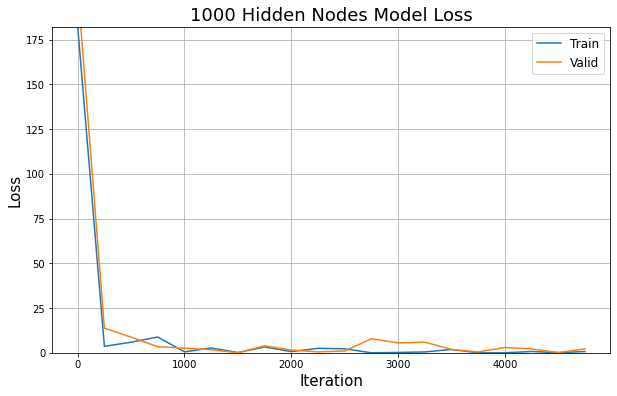

In [30]:
plot_loss(hnd_loss_record_train, hnd_loss_record_valid, params_dict['comment'])

##### 2.3.3 The Number of Epochs

In [31]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 100},
    'n_output': 10, 'LR': 0.0001, 'comment': '10000 Iteration',
    'n_batch': 50, 'n_iter': 10000, 'n_prt': 250, 'base': base_test_acc
}

iter_test_acc, iter_loss_record_train, iter_loss_record_valid = run_session(params_dict)

2021-10-26 10:13:14.899498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:13:14.900424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:13:14.901311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:13:14.902191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:13:14.902252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 56.174705505371094
Iter: 250 	Cost: 2.918362617492676
Iter: 500 	Cost: 1.121809959411621
Iter: 750 	Cost: 0.535000205039978
Iter: 1000 	Cost: 1.1829437017440796
Iter: 1250 	Cost: 0.7297961711883545
Iter: 1500 	Cost: 0.3661690950393677
Iter: 1750 	Cost: 0.708204984664917
Iter: 2000 	Cost: 0.1762978583574295
Iter: 2250 	Cost: 1.3955966234207153
Iter: 2500 	Cost: 0.3134075403213501
Iter: 2750 	Cost: 1.4138433933258057
Iter: 3000 	Cost: 0.7354017496109009
Iter: 3250 	Cost: 0.11722704768180847
Iter: 3500 	Cost: 0.4121323823928833
Iter: 3750 	Cost: 0.26272761821746826
Iter: 4000 	Cost: 0.11783650517463684
Iter: 4250 	Cost: 1.0686137676239014
Iter: 4500 	Cost: 0.45244160294532776
Iter: 4750 	Cost: 0.179764524102211
Iter: 5000 	Cost: 0.15935347974300385
Iter: 5250 	Cost: 0.4817124903202057
Iter: 5500 	Cost: 0.3251492977142334
Iter: 5750 	Cost: 0.20883823931217194
Iter: 6000 	Cost: 0.2730213701725006
Iter: 6250 	Cost: 0.16686385869979858
Iter: 6500 	Cost: 0.4321432113647461
Iter:

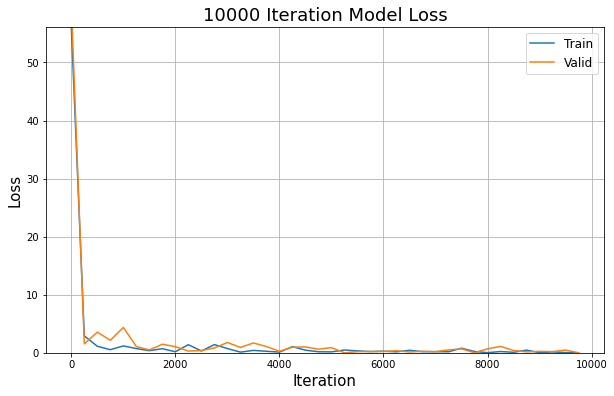

In [32]:
plot_loss(iter_loss_record_train, iter_loss_record_valid, params_dict['comment'])

##### 2.3.4 Learning Rate

In [35]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 100},
    'n_output': 10, 'LR': 0.001, 'comment': '0.01 Learning Rate',
    'n_batch': 50, 'n_iter': 5000, 'n_prt': 250, 'base': base_test_acc
}

lr_test_acc, lr_loss_record_train, lr_loss_record_valid = run_session(params_dict)

2021-10-26 10:14:08.118020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:14:08.118898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:14:08.119770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:14:08.120586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:14:08.120638: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 36.887786865234375
Iter: 250 	Cost: 0.65044766664505
Iter: 500 	Cost: 0.6540930271148682
Iter: 750 	Cost: 0.3125479221343994
Iter: 1000 	Cost: 0.4072936177253723
Iter: 1250 	Cost: 0.3689382076263428
Iter: 1500 	Cost: 0.24013414978981018
Iter: 1750 	Cost: 0.025305628776550293
Iter: 2000 	Cost: 0.13098323345184326
Iter: 2250 	Cost: 0.06545703113079071
Iter: 2500 	Cost: 0.09139660000801086
Iter: 2750 	Cost: 0.198481947183609
Iter: 3000 	Cost: 0.16957950592041016
Iter: 3250 	Cost: 0.08506514877080917
Iter: 3500 	Cost: 0.08809150010347366
Iter: 3750 	Cost: 0.05956299602985382
Iter: 4000 	Cost: 0.07606115192174911
Iter: 4250 	Cost: 0.06839440017938614
Iter: 4500 	Cost: 0.07694429904222488
Iter: 4750 	Cost: 0.07797285169363022


0.01 Learning Rate Test Accuracy: 94.77% (base: 92.99%)


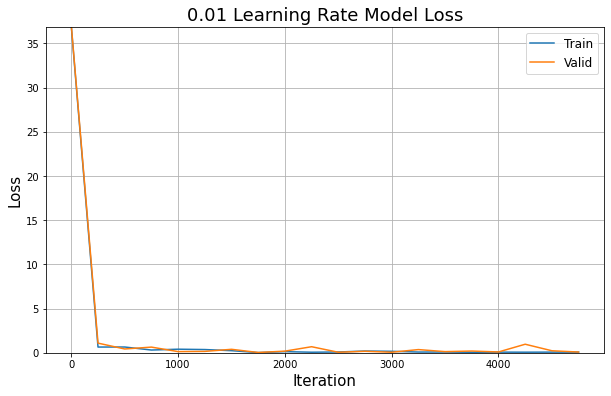

In [36]:
plot_loss(lr_loss_record_train, lr_loss_record_valid, params_dict['comment'])

#### 2.4 Discuss the results (20 pt)

 * you can use either Microsoft Word or markdown

##### 2.4.1 The Number of Hidden Layers

In [37]:
print('{} Test Accuracy: {}% (base: {}%)'.format(
      '2 Hidden Layers', round(hly_test_acc*100, 4), round(base_test_acc*100, 4)))

2 Hidden Layers Test Accuracy: 94.27% (base: 92.99%)


With increasing hidden layers from 1 to 2, I got higher test accuracy than base one like the above.
It's simply understood because nonlinear classifier in original space 
could be handled with multi layers separating them linearly in z space.
However, there's always a risk to put many layers which may lead to overfitting.

##### 2.4.2 The Number of Hidden Nodes

In [38]:
print('{} Test Accuracy: {}% (base: {}%)'.format(
      '1000 Hidden Nodes', round(hnd_test_acc*100, 4), round(base_test_acc*100, 4)))

1000 Hidden Nodes Test Accuracy: 94.87% (base: 92.99%)


With increasing hidden layer's nodes from 100 to 1000, I got higher test accuracy than base one like the above. It's basically because of the concept of the hidden layer.
The hidden layer learns a representation so that the data gets linearly separable.
The more neurons in hidden layers, the more multiple linear classification boundaries.

##### 2.4.3 The Number of Epochs

In [39]:
print('{} Test Accuracy: {}% (base: {}%)'.format(
      '10000 Iteration', round(iter_test_acc*100, 4), round(base_test_acc*100, 4)))

10000 Iteration Test Accuracy: 94.91% (base: 92.99%)


With increasing iteration from 5000 to 10000, I got higher test accuracy than base one like the above.
The more the number of iterations, the better learning and the higher test accuracy.
However, there're a tradeoff with the cost of calculating weights and biases and a risk of overfitting.

##### 2.4.4 Learning Rate

In [40]:
print('{} Test Accuracy: {}% (base: {}%)'.format(
      '0.01 Iteration', round(lr_test_acc*100, 4), round(base_test_acc*100, 4)))

0.01 Iteration Test Accuracy: 94.77% (base: 92.99%)


With chaning learning rate from 0.0001 to 0.001, I got higher test accuracy than base one like the above.
It did not get underfitting making divergence which I can say 0.01 is the optimal learning rate.

### 3. Improve your model

 <strong>※ For all your training results, plot the training and validation curve and report the test accuracy</strong>

#### 3.1 Try to improve your model by following modifications for each case (use your base model) (20 pt)

* Add dropout
* Apply data augmentation (visualize the augmented data)
* Change the optimizer
* Use learning rate scheduler
* Add regularization

In [58]:
def run_session(params):
    def build_model(x, weights, biases, p):
        nonlocal layer_num

        hidden = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
        hidden_final = tf.nn.relu(hidden)
        if p != 0:
            hidden_final = tf.nn.dropout(hidden_final, rate=p)
        
        if layer_num == 3:
            hidden_middle = tf.add(tf.matmul(hidden_final, 
                                             weights['hidden_middle']), 
                                             biases['hidden_middle'])
            hidden_final = tf.nn.relu(hidden_middle)
            if p != 0:
                hidden_final = tf.nn.dropout(hidden_final, rate=p)

        output = tf.add(tf.matmul(hidden_final, weights['output']), biases['output'])

        return output

    layer_num = len(params['n_hiddens']) + 1
    
    n_input, n_output = params['n_input'], params['n_output']
    LR, n_batch = params['LR'], params['n_batch']
    n_iter, n_prt = params['n_iter'], params['n_prt']
    
    n_hidden = params['n_hiddens']['n_hidden']
    
    weights = {'hidden': tf.Variable(tf.random.normal([n_input, n_hidden], stddev=0.05))}
    biases = {'hidden': tf.Variable(tf.random_normal([n_hidden], stddev=0.05)),
              'output': tf.Variable(tf.random_normal([n_output], stddev=0.05))}
    if layer_num == 2:
        weights['output'] = tf.Variable(tf.random.normal([n_hidden, n_output], stddev=0.05))
        
    if layer_num == 3:
        n_hidden_middle = params['n_hiddens']['n_hidden_middle']
        
        weights['hidden_middle'] = tf.Variable(
            tf.random.normal([n_hidden, n_hidden_middle], stddev=0.05))
        weights['output'] = tf.Variable(
            tf.random.normal([n_hidden_middle, n_output], stddev=0.05))
        biases['hidden_middle'] = tf.Variable(
            tf.random_normal([n_hidden_middle], stddev=0.05))
    
    p_rate = params['dropout'] if 'dropout' in params else 0
        
    p = tf.placeholder(tf.float32)    
    x = tf.compat.v1.placeholder(tf.float32, [None, n_input])
    y = tf.compat.v1.placeholder(tf.float32, [None, n_output])

    pred = build_model(x, weights, biases, p_rate)
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y)
    loss = tf.reduce_mean(loss)
    
    if 'reg' in params:
        _lambda = params['reg']
        
        reg_1 = tf.reduce_mean(tf.square(weights['hidden']))
        reg_2 = tf.reduce_mean(tf.square(weights['output'])) 
        reg_3 = tf.reduce_mean(tf.square(biases['hidden'])) 
        reg_4 = tf.reduce_mean(tf.square(biases['output']))
        # add all weights and multiply by lambda
        loss = tf.reduce_mean(loss + _lambda*(reg_1 + reg_2 + reg_3 + reg_4))

    if 'optm' in params:
        optm = tf.compat.v1.train.AdagradOptimizer(LR).minimize(loss)
    
    elif 'schd' in params:
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 0.001
        LR = tf.compat.v1.train.exponential_decay(starter_learning_rate,
                                                  global_step, 50, 0.96, 
                                                  staircase=True)
        optm = tf.compat.v1.train.AdamOptimizer(LR).minimize(loss, global_step=global_step)
    
    else:
        optm = tf.compat.v1.train.AdamOptimizer(LR).minimize(loss)
    init = tf.compat.v1.global_variables_initializer()

    loss_record_train = []
    loss_record_valid = []
    with tf.compat.v1.Session() as sess:
        sess.run(init)
        for epoch in range(n_iter):
            train_x, train_y = next_batch(n_batch, 
                                          X_train_augmented, y_train_augmented) \
                               if 'augmented' in params else \
                               next_batch(n_batch, X_train, y_train)
            sess.run(optm, feed_dict={x: train_x, y: train_y, p: p_rate}) 

            if epoch % n_prt == 0:        
                valid_x, valid_y = next_batch(n_batch, X_valid, y_valid)
                c1 = sess.run(loss, feed_dict={x: train_x, y: train_y, p: p_rate})
                c2 = sess.run(loss, feed_dict={x: valid_x, y: valid_y, p: 0})
                loss_record_train.append(c1)
                loss_record_valid.append(c2)
                print ('Iter: {} \tCost: {}'.format(epoch, c1))

        #test accuracy
        test_x, test_y = X_test, y_test

        my_pred = sess.run(pred, feed_dict={x: test_x})
        my_pred = np.argmax(my_pred, axis=1)
        labels = np.argmax(test_y, axis=1)

        test_acc = np.mean(np.equal(my_pred, labels))
        if 'base' in params_dict:
            print('\n\n{} Test Accuracy: {}% (base: {}%)'.format(
                params['comment'], round(test_acc*100, 4), round(params['base']*100, 4)))
        else:
            print('\n\n{} Test Accuracy: {}%'.format(
                params['comment'], round(test_acc*100, 4)))
        
    return test_acc, loss_record_train, loss_record_valid

##### 3.1.1 Add Dropout

In [44]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 500}, 'dropout': 0.15,
    'n_output': 10, 'LR': 0.0001, 'comment': 'Dropout',
    'n_batch': 50, 'n_iter': 5000, 'n_prt': 250, 'base': base_test_acc
}

dp_test_acc, dp_loss_record_train, dp_loss_record_valid = run_session(params_dict)

2021-10-26 10:15:53.394870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:15:53.395684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:15:53.396455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:15:53.397213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:15:53.397267: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 167.02296447753906
Iter: 250 	Cost: 8.833756446838379
Iter: 500 	Cost: 8.685235977172852
Iter: 750 	Cost: 4.145505428314209
Iter: 1000 	Cost: 5.86236572265625
Iter: 1250 	Cost: 6.635435581207275
Iter: 1500 	Cost: 1.7065576314926147
Iter: 1750 	Cost: 2.0183722972869873
Iter: 2000 	Cost: 0.8197567462921143
Iter: 2250 	Cost: 2.1823487281799316
Iter: 2500 	Cost: 1.6630969047546387
Iter: 2750 	Cost: 0.00045243758358992636
Iter: 3000 	Cost: 1.7581706047058105
Iter: 3250 	Cost: 1.4439706802368164
Iter: 3500 	Cost: 1.2415952682495117
Iter: 3750 	Cost: 0.014456096105277538
Iter: 4000 	Cost: 0.2005162090063095
Iter: 4250 	Cost: 0.8637592196464539
Iter: 4500 	Cost: 1.0044758319854736
Iter: 4750 	Cost: 0.7728093862533569


Dropout Test Accuracy: 94.04% (base: 92.99%)


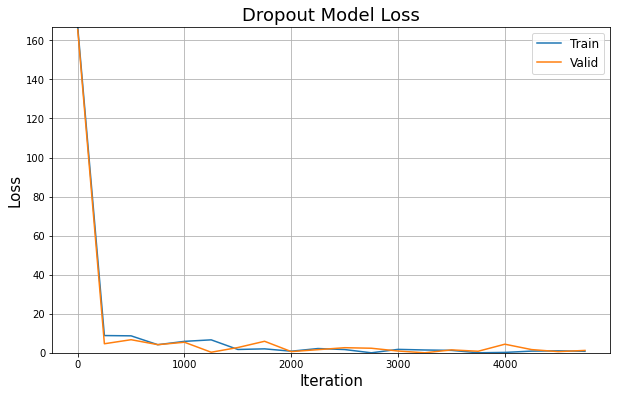

In [45]:
plot_loss(dp_loss_record_train, dp_loss_record_valid, params_dict['comment'])

##### 3.1.2 Apply Data Augmentation (Visualize the augmented data)

In [46]:
from scipy.ndimage.interpolation import shift

# Method to shift the image by given dimension
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    
    return shifted_image.reshape([-1])

# Create Augmented Dataset
X_train_augmented = [image for image in X_train]
y_train_augmented = [image for image in y_train]

count = 0
list_images = []
for image, label in zip(X_train, y_train):
    list_images.append(image)
    for dx, dy in ((2, 0), (-2, 0), (0, 2), (0, -2)):
        image_shifted = shift_image(image, dx, dy)
        if count < 3:
            count += 1
            list_images.append(image_shifted)
        
        X_train_augmented.append(image_shifted)
        y_train_augmented.append(label)

# Shuffle the dataset
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = np.array(X_train_augmented)[shuffle_idx]
y_train_augmented = np.array(y_train_augmented)[shuffle_idx]

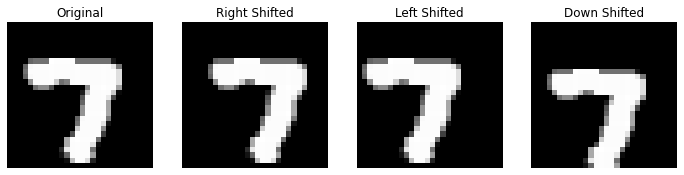

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
for i in range(4):
    title = 'Original' if i == 0 else ('Right Shifted' if i == 1 else(
        'Left Shifted' if i == 2 else 'Down Shifted'))
    ax[i].imshow(list_images[i].reshape([28, 28]), 'gray')
    ax[i].set_title(title)
    ax[i].axis('off')
plt.show()

In [50]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 100}, 'augmented': True,
    'n_output': 10, 'LR': 0.0001, 'comment': 'Data Augmentation',
    'n_batch': 500, 'n_iter': 5000, 'n_prt': 250, 'base': base_test_acc
}

ag_test_acc, ag_loss_record_train, ag_loss_record_valid = run_session(params_dict)

2021-10-26 10:17:29.714811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:17:29.715726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:17:29.716630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:17:29.717558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:17:29.717620: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 61.07304000854492
Iter: 250 	Cost: 4.609750747680664
Iter: 500 	Cost: 2.0868031978607178
Iter: 750 	Cost: 1.6522204875946045
Iter: 1000 	Cost: 1.4807591438293457
Iter: 1250 	Cost: 1.1756669282913208
Iter: 1500 	Cost: 0.8717741966247559
Iter: 1750 	Cost: 0.7117028832435608
Iter: 2000 	Cost: 0.6390981078147888
Iter: 2250 	Cost: 0.525610089302063
Iter: 2500 	Cost: 0.7253072261810303
Iter: 2750 	Cost: 0.4699658155441284
Iter: 3000 	Cost: 0.4263070225715637
Iter: 3250 	Cost: 0.36948102712631226
Iter: 3500 	Cost: 0.4352777600288391
Iter: 3750 	Cost: 0.3145025670528412
Iter: 4000 	Cost: 0.3878771960735321
Iter: 4250 	Cost: 0.21734599769115448
Iter: 4500 	Cost: 0.26425763964653015
Iter: 4750 	Cost: 0.2619507610797882


Data Augmentation Test Accuracy: 94.58% (base: 92.99%)


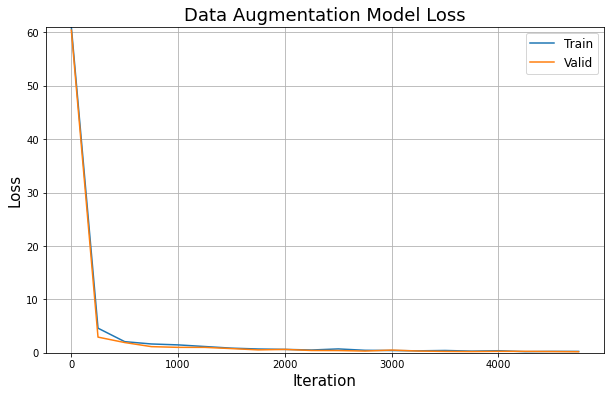

In [51]:
plot_loss(ag_loss_record_train, ag_loss_record_valid, params_dict['comment'])

##### 3.1.3 Change the Optimizer

In [52]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 100}, 'optm': True,
    'n_output': 10, 'LR': 0.015, 'comment': 'Adagrad Optimizer',
    'n_batch': 50, 'n_iter': 5000, 'n_prt': 250, 'base': base_test_acc
}

op_test_acc, op_loss_record_train, op_loss_record_valid = run_session(params_dict)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2021-10-26 10:18:14.795959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:18:14.796901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:18:14.797835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:18:14.798773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:18:14.798837: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 252.82998657226562
Iter: 250 	Cost: 0.3659564256668091
Iter: 500 	Cost: 0.4145611524581909
Iter: 750 	Cost: 0.43788784742355347
Iter: 1000 	Cost: 0.12473253160715103
Iter: 1250 	Cost: 0.0948764830827713
Iter: 1500 	Cost: 0.12313785403966904
Iter: 1750 	Cost: 0.2737594544887543
Iter: 2000 	Cost: 0.2325926572084427
Iter: 2250 	Cost: 0.13002285361289978
Iter: 2500 	Cost: 0.2030918151140213
Iter: 2750 	Cost: 0.19677889347076416
Iter: 3000 	Cost: 0.2907164990901947
Iter: 3250 	Cost: 0.25645220279693604
Iter: 3500 	Cost: 0.15479658544063568
Iter: 3750 	Cost: 0.05431724712252617
Iter: 4000 	Cost: 0.18216639757156372
Iter: 4250 	Cost: 0.18002183735370636
Iter: 4500 	Cost: 0.021703427657485008
Iter: 4750 	Cost: 0.21083703637123108


Adagrad Optimizer Test Accuracy: 93.72% (base: 92.99%)


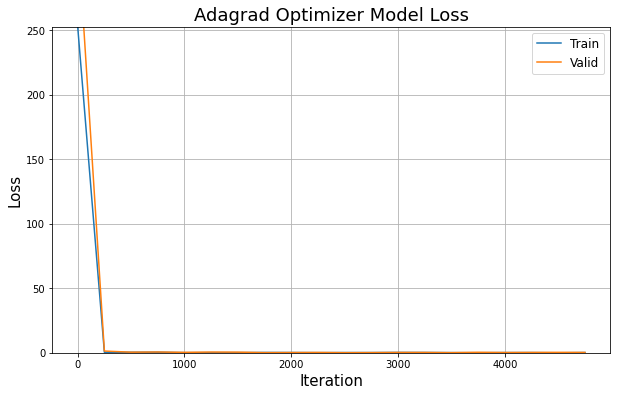

In [53]:
plot_loss(op_loss_record_train, op_loss_record_valid, params_dict['comment'])

##### 3.1.4 Use Learning Rate Scheduler

In [59]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 100}, 'schd': True,
    'n_output': 10, 'LR': 0.0001, 'comment': 'Learning Rate Scheduler',
    'n_batch': 50, 'n_iter': 5000, 'n_prt': 250, 'base': base_test_acc
}

schd_test_acc, schd_loss_record_train, schd_loss_record_valid = run_session(params_dict)

2021-10-26 10:20:11.276685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:20:11.277615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:20:11.278558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:20:11.279502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:20:11.279562: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 55.072750091552734
Iter: 250 	Cost: 0.5571300983428955
Iter: 500 	Cost: 0.32351672649383545
Iter: 750 	Cost: 0.18262429535388947
Iter: 1000 	Cost: 0.2278846800327301
Iter: 1250 	Cost: 0.11874555796384811
Iter: 1500 	Cost: 0.19069701433181763
Iter: 1750 	Cost: 0.08250127732753754
Iter: 2000 	Cost: 0.3163143992424011
Iter: 2250 	Cost: 0.21292535960674286
Iter: 2500 	Cost: 0.13493052124977112
Iter: 2750 	Cost: 0.15766781568527222
Iter: 3000 	Cost: 0.05256245657801628
Iter: 3250 	Cost: 0.050796523690223694
Iter: 3500 	Cost: 0.16966590285301208
Iter: 3750 	Cost: 0.1762360781431198
Iter: 4000 	Cost: 0.09339241683483124
Iter: 4250 	Cost: 0.08914010971784592
Iter: 4500 	Cost: 0.058252498507499695
Iter: 4750 	Cost: 0.21573692560195923


Learning Rate Scheduler Test Accuracy: 94.68% (base: 92.99%)


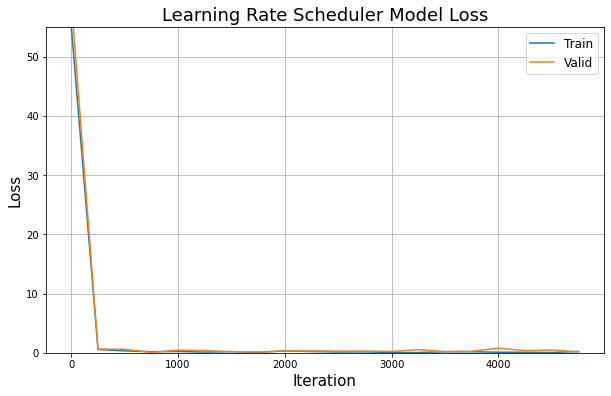

In [60]:
plot_loss(schd_loss_record_train, schd_loss_record_valid, params_dict['comment'])

##### 3.1.5 Add Regularization

In [64]:
params_dict  = {
    'n_input': 784, 'n_hiddens': {'n_hidden': 100}, 'reg': 0.001,
    'n_output': 10, 'LR': 0.0001, 'comment': 'Regularization',
    'n_batch': 50, 'n_iter': 5000, 'n_prt': 250, 'base': base_test_acc
}

reg_test_acc, reg_loss_record_train, reg_loss_record_valid = run_session(params_dict)

2021-10-26 10:21:57.487121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:18:00.0
2021-10-26 10:21:57.488009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:3b:00.0
2021-10-26 10:21:57.488884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:86:00.0
2021-10-26 10:21:57.489973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:af:00.0
2021-10-26 10:21:57.490038: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
20

Iter: 0 	Cost: 100.14186096191406
Iter: 250 	Cost: 3.6485936641693115
Iter: 500 	Cost: 1.0341498851776123
Iter: 750 	Cost: 2.4062962532043457
Iter: 1000 	Cost: 0.4465271532535553
Iter: 1250 	Cost: 0.9681121110916138
Iter: 1500 	Cost: 0.2531859874725342
Iter: 1750 	Cost: 0.926330029964447
Iter: 2000 	Cost: 0.4639686048030853
Iter: 2250 	Cost: 0.8083465695381165
Iter: 2500 	Cost: 1.0365146398544312
Iter: 2750 	Cost: 0.915116012096405
Iter: 3000 	Cost: 0.8984185457229614
Iter: 3250 	Cost: 0.3110281825065613
Iter: 3500 	Cost: 0.31334030628204346
Iter: 3750 	Cost: 0.10066234320402145
Iter: 4000 	Cost: 0.7387018799781799
Iter: 4250 	Cost: 0.1750970482826233
Iter: 4500 	Cost: 0.35346654057502747
Iter: 4750 	Cost: 0.3533816635608673


Regularization Test Accuracy: 93.11% (base: 92.99%)


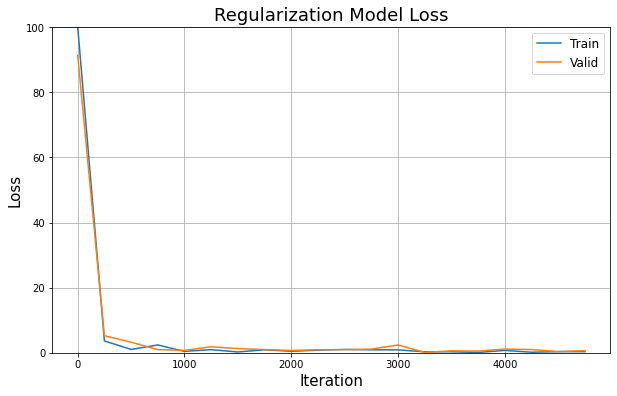

In [65]:
plot_loss(reg_loss_record_train, reg_loss_record_valid, params_dict['comment'])

#### 3.2 Discuss the results (20 pt)

 * you can use either Microsoft Word or markdown

##### 3.2.1 Add Dropout

In [66]:
print('{} Test Accuracy: {}% (base: {}%)'.format(
      'Dropout', round(dp_test_acc*100, 4), round(base_test_acc*100, 4)))

Dropout Test Accuracy: 94.04% (base: 92.99%)


Dropout is the one of the most interesting types of regularization techniques.
At every iteration, it randomly selects some nodes and removes them
so that it makes a different architecture at every training epoch.
Consequently, it can be thought of as an ensemble technique in machine learning.
An ensemble technique usually makes better performance than the base one.
Adding the dropout with the rate of 0.15, the test accuracy slightly increased like the above.
However, since the base hidden layer's nodes are not enough to be complex and dropped out,
it doesn't make much change.

##### 3.2.2 Apply Data Augmentation

In [72]:
print('{} Test Accuracy: {}% (base: {}%)'.format(
      'Data Augmentation', round(ag_test_acc*100, 4), round(base_test_acc*100, 4)))
print('Before: {} -> After: {}'.format(X_train.shape, X_train_augmented.shape))

Data Augmentation Test Accuracy: 94.58% (base: 92.99%)
Before: (50000, 784) -> After: (250000, 784)


Doing the data augmentation with the horizontal and vertical shift technique, 
the size of train set become five times larger. And the test accuracy slightly increased like the above.
Data augmentation is the simplest way to reduce overfitting as increasing the size of the training data.
That's why I increased the size of batch as I increased the size of the training data with the shift.

##### 3.2.3 Change the Optimizer

In [68]:
print('{} Test Accuracy: {}% (base: {}%)'.format(
      'Adagrad Optimizer', round(op_test_acc*100, 4), round(base_test_acc*100, 4)))

Adagrad Optimizer Test Accuracy: 93.72% (base: 92.99%)


The test accuracy slightly increased like the above as changing the optimizer from AdamOptimizer to Adagrad.
Adagrad is an optimizer with parameter-specific learning rates, 
which are adapted relative to how frequently a parameter gets updated during training. 
The more updates a parameter receives, the smaller the updates.
So I adjusted the learning rate to 0.015 to fasten up the speed of learning since it's not the same optimizer.
However, rather than changing the optimizer, I thought it would be more efficient to change other parameters first to get the better performance.

##### 3.2.4 Use Learning Rate Scheduler

In [69]:
print('{} Test Accuracy: {}% (base: {}%)'.format(
      'Learning Rate Scheduler', round(schd_test_acc*100, 4), round(base_test_acc*100, 4)))

Learning Rate Scheduler Test Accuracy: 94.68% (base: 92.99%)


Learning rate schedules seek to adjust the learning rate during training 
by reducing the learning rate according to a pre-defined schedule.
I put the learning rate scheduler provided by tensorflow. It changes 0.001 learning rate slowly 
in the direction of decreasing with the rate of parameter in which I chose to put as 0.96.
As you can see, the test accuracy slightly increased like the above.

##### 3.2.5 Add Regularization

In [70]:
print('{} Test Accuracy: {}% (base: {}%)'.format(
      'Regularization', round(reg_test_acc*100, 4), round(base_test_acc*100, 4)))

Regularization Test Accuracy: 93.11% (base: 92.99%)


Often, overfitting associated with very large estimated parameters. 
We want to balance how well function fits data and magnitude of coefficients.
So I used L2 regularization method with 0.001 lambda.
L2 regularization acts like a force that removes a small percentage of weights at each iteration.
Therefore, weights will never be equal to zero.
It worked with the test accuracy very slightly increasing like the above.
I assume that L2 regularization should be used with other parameter changing or in more complex model. 